In [1]:
from __future__ import division, print_function
from astropy.table import Table
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import ebf
import os

In [11]:
def unbound_only():
    # remove bound sat stars
    satprop = ebf.read('./satprop.ebf')
    for table_fh in [f for f in os.listdir(os.path.curdir) if f.endswith('.hdf5')]:
        print(table_fh)
        table = Table.read(table_fh, format='hdf5', path='data')
        print(len(table))
        for satid in range(int(table.meta['sat0']), int(table.meta['sat1'])):
            if satprop['bsat'][satid]:
                #print ' --> ', satid
                remove = np.nonzero(table['satids'] == satid)
                #print ' --> ', len(remove)
                table.remove_rows(remove)
        print(len(table))    
        table.write(table_fh, format='hdf5', path='data', overwrite=True)

In [13]:
unbound_only()

halo08_4.0Mpc_h158_table.hdf5
2232218
1647096
halo15_4.0Mpc_h158_table.hdf5
1837252
1755352
halo20_4.0Mpc_h158_table.hdf5
1720668
1687227


In [4]:
halo_table = Table.read('./halo08_4.0Mpc_h158_table.hdf5', path='data')
for key in halo_table.meta.keys():
    print(key, halo_table.meta[key])

halo halo08
abm_lim -0.89
m_lims ['29.0', '28.0', '27.0']
d_mpc 4.0
f_type h158
sat0 416
sat1 574
n_sats 157
spinbin_output_fh C:\Users\swc21\skysurvey\tables\spinbin_output\halo08_4.0Mpc_h158_table.hdf5


In [7]:
for i in range(1, 10, 1):
    print(i, 600.0 * kpc_to_arcmin(i), 600 * kpc_to_arcsec(i))

1 2062.64737492 123758.842495
2 1031.32394529 61879.4367175
3 687.549328692 41252.9597215
4 515.662004875 30939.7202925
5 412.529606994 24751.7764196
6 343.774673895 20626.4804337
7 294.66400692 17679.8404152
8 257.831006466 15469.860388
9 229.183117109 13750.9870266


In [14]:
fh = 'halo08_4.0Mpc_h158_table.hdf5'

In [16]:
fh.split('_')[2]

'h158'

In [17]:
fh.replace('h158', 'CMD')

'halo08_4.0Mpc_CMD_table.hdf5'

In [6]:
def kpc_to_arcmin(d_mpc):
    d = 1e3
    D = d_mpc * 1e6
    arcmin_mod = (60.0 * 180.0) / np.pi
    return arcmin_mod * np.arctan2(d, D)

def kpc_to_sqrarcmin(d_mpc):
    d = 1e3
    D = d_mpc * 1e6
    arcmin_mod = (60.0 * 180.0) / np.pi
    return np.square(arcmin_mod * np.arctan2(d, D))

def kpc_to_arcsec(d_mpc):
    d = 1e3
    D = d_mpc * 1e6
    arcsec_mod = 206264.80624709636 #(3600.0 * 180.0) / np.pi
    return arcsec_mod * np.arctan2(d, D)

def fix_rslice(grid, d_mpc=4.0, unit='kpc', rslices=[4]):
    '''
    helper function for plot_halo()

    fills the entire grid slice for radius
    this is needed for a smooth contour over plot

    Arguments:
        grid {np.ndarray} -- the grid

    Keyword Arguments:
        rslices {list} -- slice with radius for all stars (default: {[14]})

    Returns:
        np.ndarray -- the same grid but with filled radial slice
    '''
    # TODO - determine the ratio
    # ratio = (2.0 * 300.0 / 600.0)

    # find center of grid
    x_center = (grid.shape[1] / 2)
    y_center = (grid.shape[0] / 2)
    
    # conver to arcmin
    if unit == 'arcmin':
        ratio =  kpc_to_arcmin(d_mpc)
    elif unit == 'arcsec':
        ratio =  kpc_to_arcsec(d_mpc)
    else:
        ratio = 1
    # iterate over whole grid one by one
    for r in rslices:
        for i in range(grid.shape[0]):
            for q in range(grid.shape[1]):
                value = np.sqrt((
                    np.square(i - y_center) +
                    np.square(q - x_center))
                )
                
                if value > 300.0:
                    value = 0.0
                value *= ratio
                grid[i, q, r] = value

    return grid

In [235]:
plot_units = 'arcmin'
plot_radius_kpc = 150
distance = 4.0
mod = kpc_to_sqrarcmin(distance)

C:\Users\swc21\Anaconda2\lib\site-packages\ipykernel\__main__.py:28: RuntimeWarning: divide by zero encountered in log10


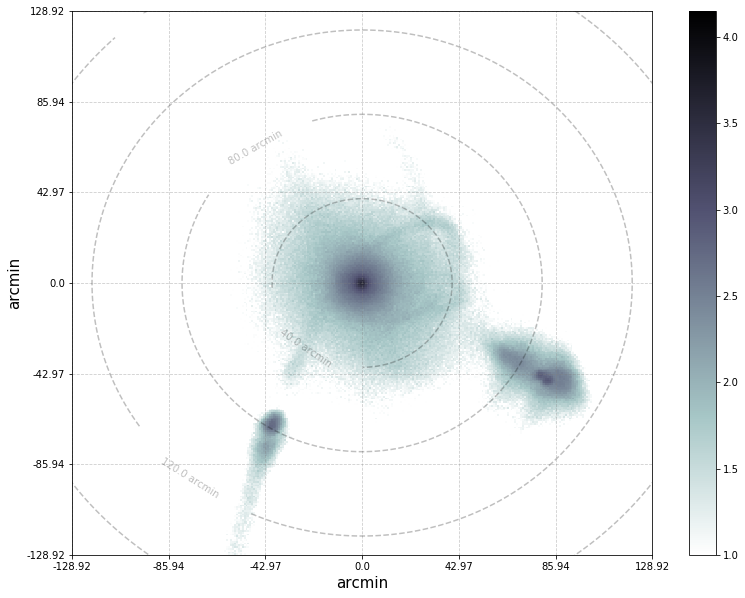

In [256]:
fig = plt.figure(figsize=(13, 10))

# make a single subplot
ax = fig.add_subplot(111)

# set titles & labels for axes & plot
ax.set_xlabel(plot_units, fontsize=15)
ax.set_ylabel(plot_units, fontsize=15)

# make & set tick labels for xy axes
# TODO - automaticly determin labels
if plot_units == 'kpc':

    _levels = None [50., 100., 150., 300.]
    clabel_frmt = '%s Kpc'
elif plot_units == 'arcmin':
    #ticks = [str(i) for i in np.linspace(-plot_radius_kpc, plot_radius_kpc, 7)]
    #ax.set_xticklabels(ticks, fontsize=10)
    #ax.set_yticklabels(ticks, fontsize=10)
    _levels = None#[50, 100, 150, 300]
    clabel_frmt = '%s arcmin'
elif plot_units == 'arcsec':
    clabel_frmt = '%s arcsec'
# fill radius grid slice for contour
grid = fix_rslice(np.load('../grids/halo08_4.0Mpc_h158_grid.npy'), d_mpc=distance, unit=plot_units)

# plot heat map
hm = ax.pcolormesh(np.log10(grid[8:, :-3, 0] * mod),
              cmap=plt.cm.bone_r,
              vmin=1.0,
              vmax=4.15)

# plot contour map to overlay on heat map
cp = ax.contour(grid[:, :, 4],
                levels=_levels,
                colors='k',
                linewidths=1.5,
                alpha=.25,
                linestyles='dashed')

# labels for contour overlay
cl = ax.clabel(cp,
               levels=_levels,
               inline=1,
               fmt=clabel_frmt,
               fontsize=10,
               color='k',
               linewidth=50,
               alpha=1)
# colorbar
cb = plt.colorbar(hm,ax=None)

# set plot xy limits
center = grid.shape[0] / 2
include = plot_radius_kpc
lim0 = center + include
lim1 = center - include
ax.set_xlim([lim1, lim0])
ax.set_ylim([lim1, lim0])

#ax.set_xlim([90 + center, 100+ center])
#ax.set_ylim([-45+ center, -55+ center])

# set unit tick labels
current_ticks = ax.axes.get_xticks()
if plot_units == 'kpc':
    ticks = current_ticks - 300

elif plot_units == 'arcmin':
    ticks = ((current_ticks - 300) * kpc_to_arcmin(distance)).round(2)

elif plot_units == 'arcsec':
    ticks = ((current_ticks - 300) * kpc_to_arcsec(distance)).round(2)
    
ax.set_xticklabels(ticks, fontsize=10)
ax.set_yticklabels(ticks, fontsize=10)
    
# plot grid
ax.axes.grid(alpha=.4, linestyle='dashed', color='grey')

plt.show()

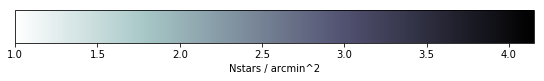

In [254]:
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cmap = mpl.cm.bone_r
norm = mpl.colors.Normalize(vmin=cb.vmin, vmax=cb.vmax)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Nstars / arcmin^2')
plt.show()

In [201]:
def kpc_to_arcsec(d_mpc):
    d = 1.0 * 1e3 # Kpc
    D = d_mpc * 1e6
    arcsec_mod = 206264.80624709636 #(3600.0 * 180.0) / np.pi
    return arcsec_mod * (d / D)



In [170]:
distance = 4.0

In [171]:
# this is a 4088 x 4088 pixel ccd detector plate
region_ccd_size = (4088, 4088)

In [172]:
# each one of it's pixesls represents 0.11 arc sec on the sky
region_pixel_size = 0.11

In [174]:
arcsec_per_kpc_ratio = kpc_to_arcsec(distance)
print('distance Mpc:', distance, 'arcsec_per_kpc_ratio:', arcsec_per_kpc_ratio)

distance Mpc: 4.0 arcsec_per_kpc_ratio: 0.0515662015618


In [123]:
kpc_per_arcsec_ratio = 1.0 / arcsec_per_kpc_ratio
print('kpc_per_arcsec_ratio:', kpc_per_arcsec_ratio)

kpc_per_arcsec_ratio: 19.3925472444


In [121]:
xpix, ypix = region_ccd_size
print('xpix, ypix: ', xpix, ypix)

xpix, ypix:  4088 4088


In [124]:
# to get arcsecs we multiply Npixel (xpix) * 0.11 arcsec/pixel (region_pixel_size)
detector_arcsec_x = xpix * region_pixel_size
detector_arcsec_y = ypix * region_pixel_size
print('detector_arcsec_x:', detector_arcsec_x)
print('detector_arcsec_y:', detector_arcsec_y)

detector_arcsec_x: 449.68
detector_arcsec_y: 449.68


In [130]:
detector_kpc_x = detector_arcsec_x * arcsec_per_kpc_ratio # kpc_per_arcsec_ratio
detector_kpc_y = detector_arcsec_y * arcsec_per_kpc_ratio # kpc_per_arcsec_ratio
print('detector_kpc_x:', detector_kpc_x)
print('detector_kpc_y:', detector_kpc_y)

detector_kpc_x: 23.1882895183
detector_kpc_y: 23.1882895183


In [131]:
segment_x = detector_kpc_x * 0.5
segment_y = detector_kpc_y * 0.5
print('segment_x:', segment_x)
print('segment_y:', segment_y)

segment_x: 11.5941447591
segment_y: 11.5941447591


In [132]:
x_now = 0
y_now = 0
print('x_now:', x_now)
print('y_now:', y_now)

x_now: 0
y_now: 0


In [133]:
xbox = (x_now - segment_x, x_now + segment_x)
ybox = (y_now + segment_y, y_now - segment_y)
print('xbox:', xbox)
print('ybox:', ybox)

xbox: (-11.594144759149287, 11.594144759149287)
ybox: (11.594144759149287, -11.594144759149287)


In [219]:
for i in range(30, 40, 1):
    print(i * 1e-1, kpc_to_arcmin(i * 1e-1))

3.0 1.14591554782
3.1 1.10895053276
3.2 1.0742958309
3.3 1.04174141381
3.4 1.01110196225
3.5 0.982213336355
3.6 0.95492963399
3.7 0.929120726238
3.8 0.904670181955
3.9 0.881473511653
